# Convolutional Neural Networks

Convolutional Neural Networks (CNNs) have revolutionized the field of computer vision by providing powerful tools for image analysis and recognition. Unlike traditional neural networks, CNNs are specifically designed to process grid-like data, such as images. They employ convolutional layers to automatically and adaptively learn spatial hierarchies of features from input images.

## Libraries

In [ ]:
# !pip install torch
# !pip install torchvision
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=5f59dad72d22c8e3b3e95551f0f9c34949a51a4b87a354aee8080dfab509028f
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm
from medmnist import DermaMNIST
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

## Utilities

In [ ]:
# Training function.
def train(epoch, model, loader, criterion, optimizer, device='cpu'):
    l = 0
    for data in tqdm(loader, desc=f'Epoch {epoch+1:03d}'):
        x = data[0].to(device)
        y = data[1].squeeze().to(device)
        out = model(x)
        loss = criterion(out, y)
        l += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return l

# Test function.
def test(model, loader, criterion, device='cpu'):
    l = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            x = data[0].to(device)
            y = data[1].squeeze().to(device)
            out = model(x)
            l += criterion(out, y)
            _, pred = torch.max(out.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            y_true += y.tolist()
            y_pred += pred.tolist()
    return l, correct / total, y_true, y_pred

## Data

We will use [MedMNIST](https://medmnist.com/), a large-scale MNIST-like collection of standardized biomedical images. In particular, the DermaMNIST dataset is considered. This dataset defines a multi-class classification problem, and contains $224 \times 224$ dermatoscopic images.

In [ ]:
issubclass(DermaMNIST, torch.utils.data.Dataset)

True

First, we create both the `Dataset` objects and the `DataLoader` objects.

Torchvision supports common computer vision transformations. These can be used to transform or augment data for training or inference. Here, a sequence of spatial transformations is applied to the training data. This approach makes sure that, at every training iteration, all images are subject to such transformations, thus preventing overfitting.

In [ ]:
# Training transformations.
train_transformations = transforms.Compose([
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Datasets.
train_dataset = DermaMNIST(split='train',
                           transform=train_transformations,
                           download=True,
                           size=224)
test_dataset = DermaMNIST(split='test',
                          transform=transforms.ToTensor(),
                          download=True,
                          size=224)

# Loaders.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64,
                                          shuffle=False)

100%|██████████| 1091112502/1091112502 [01:00<00:00, 18089065.03it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist_224.npz


The distribution of classes in our dermatologic image dataset is significantly imbalanced, highlighting a crucial consideration in model evaluation. Relying solely on accuracy as a metric may not provide an accurate reflection of the model's performance, as it could be disproportionately influenced by the majority class. To address this imbalance, we need to explore alternative evaluation metrics and strategies. Augmenting the minority classes is one viable approach to mitigate this issue, but others can be considered (e.g., using class weights in the evaluation of the loss function).

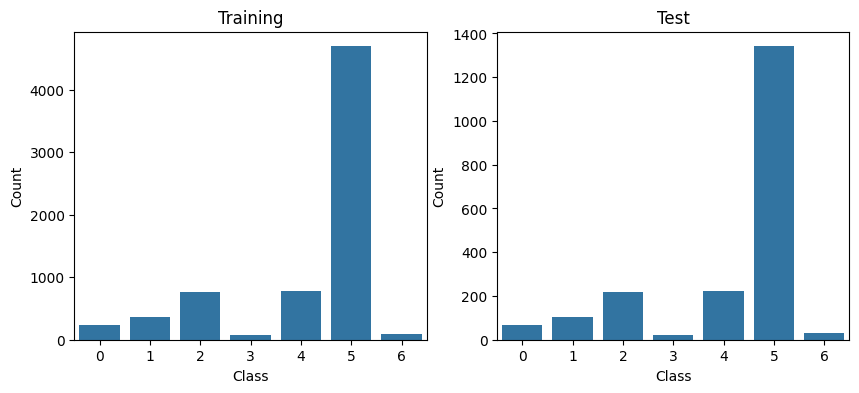

In [ ]:
# From label index to label name.
labels_map = {
    0: 'actinic keratoses and intraepithelial carcinoma',
    1: 'basal cell carcinoma',
    2: 'benign keratosis-like lesions',
    3: 'dermatofibroma',
    4: 'melanoma',
    5: 'melanocytic nevi',
    6: 'vascular lesions'
}

# Training and test distributions.
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=[label[0] for img, label in train_dataset], ax=ax[0])
sns.countplot(x=[label[0] for img, label in test_dataset], ax=ax[1])
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
plt.show()

In the context of dermatologic images, a multi-class dataset with similarities among different classes presents a unique challenge for CNNs. Dermatologic conditions often share visual characteristics, making accurate classification a difficult task. This dataset allows us to explore the robustness of CNNs in distinguishing subtle differences between similar-looking skin conditions, a task that is critical for accurate diagnosis and treatment planning.

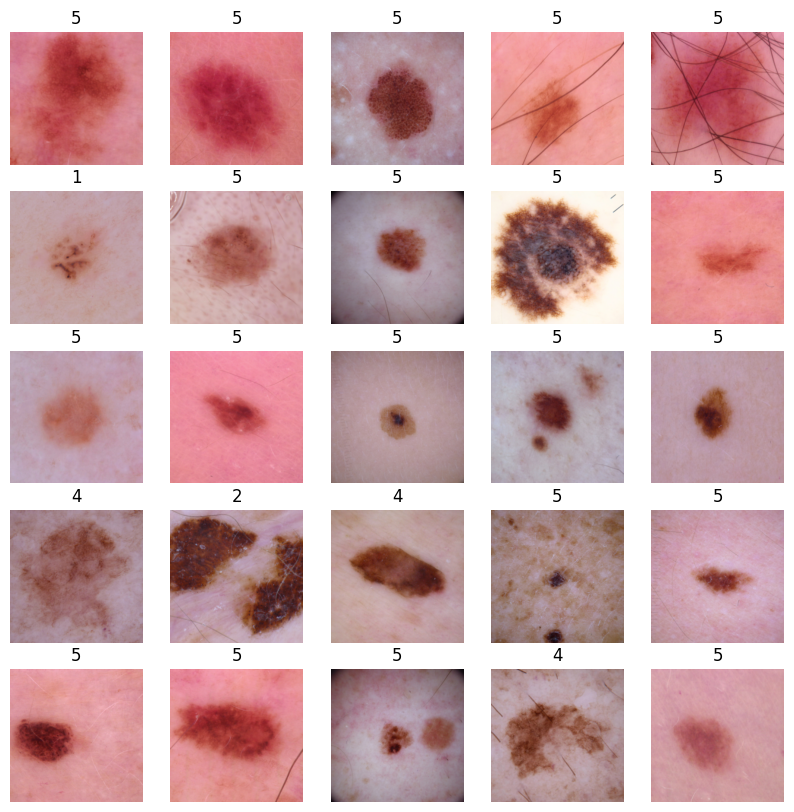

In [ ]:
# Plotting 100 training images.
fig = plt.figure(figsize=(10, 10))
rows, cols = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
    img, label = test_dataset[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label[0])
    plt.axis('off')
    plt.imshow(img.moveaxis(0, -1))
plt.show()

## Model Definition

First, we set up our system to utilize a GPU if available. Remember, every time you want to train of test a model, both the input data and the model must be on the same device. In general, `torch.tensor` objects and `nn.Module` objects can be moved to the proper device using `.to(device)`.

Then, we define a few key parameters:
- The number of classes we're working with (`num_classes`).
- The duration of training (`num_epochs`).
- The pace at which our model learns (`learning_rate`).

Our CNN, defined by the `ConvNet` class, is composed of two convolutional layers, each incorporating rectified linear unit (ReLU) activation functions and max-pooling operations. These layers play the role of discerning distinctive features within the dermatologic images. Following these convolutional layers, a fully connected layer is used to make the final classification decision.



In [ ]:
# Device configuration.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters.
num_classes = 7
num_epochs = 10
learning_rate = 0.001

# Convolutional neural network.
class ConvNet(nn.Module):

    # Constructor.
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3)
        )
        self.fc = nn.Linear(23 * 23 * 16, num_classes)

    # Forward pass.
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# Create the model.
model = ConvNet(num_classes).to(device)

## Training and Test

Firstly, we define the loss function using `nn.CrossEntropyLoss`, a suitable choice for multi-class classification tasks like ours. This function quantifies the disparity between the predicted class probabilities and the actual class labels.

Moving on to optimization, we employ the Adam optimizer, a popular choice for its adaptive learning rate properties.

We finally train and test the model for ten epochs. At the end of each epoch we print both the training and test loss, as well as the test accuracy.

In [ ]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

Epoch 001: 100%|██████████| 110/110 [00:14<00:00,  7.57it/s]


Epoch 001: training loss 115.8800, test loss 29.6530, test acc 0.6703


Epoch 002: 100%|██████████| 110/110 [00:12<00:00,  9.07it/s]


Epoch 002: training loss 102.9407, test loss 28.7526, test acc 0.6758


Epoch 003: 100%|██████████| 110/110 [00:18<00:00,  6.01it/s]


Epoch 003: training loss 100.3573, test loss 28.2857, test acc 0.6743


Epoch 004: 100%|██████████| 110/110 [00:15<00:00,  7.28it/s]


Epoch 004: training loss 97.6657, test loss 28.8118, test acc 0.6908


Epoch 005: 100%|██████████| 110/110 [00:12<00:00,  8.91it/s]


Epoch 005: training loss 96.8433, test loss 28.4368, test acc 0.6843


Epoch 006: 100%|██████████| 110/110 [00:12<00:00,  8.94it/s]


Epoch 006: training loss 95.6738, test loss 27.2839, test acc 0.6803


Epoch 007: 100%|██████████| 110/110 [00:12<00:00,  9.01it/s]


Epoch 007: training loss 93.1721, test loss 26.6872, test acc 0.6963


Epoch 008: 100%|██████████| 110/110 [00:12<00:00,  8.97it/s]


Epoch 008: training loss 91.2477, test loss 26.4197, test acc 0.6938


Epoch 009: 100%|██████████| 110/110 [00:12<00:00,  8.48it/s]


Epoch 009: training loss 88.4199, test loss 26.0049, test acc 0.6918


Epoch 010: 100%|██████████| 110/110 [00:12<00:00,  8.97it/s]


Epoch 010: training loss 85.0502, test loss 26.4794, test acc 0.7047


Given the class imbalance in our dermatologic image dataset, it's crucial to recognize that accuracy alone may not be the most suitable metric for evaluating our model's performance. The dataset exhibits varying class frequencies, leading to a situation where the majority class might dominate the accuracy metric, potentially masking the model's performance on minority classes. As a result, we need to complement accuracy with other metrics. In this case, we mainly focus on the macro F1-score.

In [ ]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.41      0.24      0.30        66
           1       0.43      0.12      0.18       103
           2       0.37      0.51      0.43       220
           3       0.00      0.00      0.00        23
           4       0.37      0.19      0.25       223
           5       0.81      0.91      0.86      1341
           6       0.70      0.24      0.36        29

    accuracy                           0.70      2005
   macro avg       0.44      0.32      0.34      2005
weighted avg       0.67      0.70      0.67      2005



In the following code cell, a particular strategy is employed to address the imbalanced nature of dataset during the training phase. To rectify the potential bias introduced by the disproportionate class distribution, the code leverages PyTorch's `WeightedRandomSampler`.

It begins by extracting the labels of the training dataset, forming a list of training targets. Subsequently, class weights are computed using the `compute_class_weight` function from scikit-learn, with the `'balanced'` option ensuring that weights are assigned inversely proportional to class frequencies. These weights are then applied to each individual image in the training set, creating a set of weights that mirrors the distribution of the classes.

The `WeightedRandomSampler` utilizes these weights to create a sampling strategy for the training dataset. By assigning higher probabilities to instances from minority classes, this sampler ensures that the model is exposed to a more balanced representation during training. This technique essentially emulates data augmentation for minority classes.

In [ ]:
# List of training labels.
train_targets = [label[0] for _, label in train_dataset]

# Computing class weights based on class frequency.
cls_weights = torch.from_numpy(compute_class_weight('balanced',
                                                    classes=np.unique(train_targets),
                                                    y=train_targets))

# Resulting array of weights.
weights = cls_weights[train_targets]

# Weighted random sampler. Used to consider copies of minority classes.
sampler = torch.utils.data.WeightedRandomSampler(weights,
                                                 len(train_targets),
                                                 replacement=True)

# Train loader.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=sampler,
                                           batch_size=64)

Once the new training loader is computed, a new model is trained for ten epochs and its performances are then evaluated.

In [ ]:
# Create the model.
model = ConvNet(num_classes).to(device)

# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(model, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

Epoch 001: 100%|██████████| 110/110 [00:12<00:00,  9.04it/s]


Epoch 001: training loss 191.1068, test loss 56.4949, test acc 0.3940


Epoch 002: 100%|██████████| 110/110 [00:12<00:00,  8.98it/s]


Epoch 002: training loss 152.3083, test loss 37.3404, test acc 0.5466


Epoch 003: 100%|██████████| 110/110 [00:12<00:00,  8.95it/s]


Epoch 003: training loss 145.2154, test loss 38.2720, test acc 0.5017


Epoch 004: 100%|██████████| 110/110 [00:12<00:00,  8.93it/s]


Epoch 004: training loss 138.3520, test loss 37.7019, test acc 0.5297


Epoch 005: 100%|██████████| 110/110 [00:12<00:00,  9.00it/s]


Epoch 005: training loss 134.8871, test loss 36.3018, test acc 0.5526


Epoch 006: 100%|██████████| 110/110 [00:12<00:00,  8.94it/s]


Epoch 006: training loss 131.1231, test loss 36.6233, test acc 0.5312


Epoch 007: 100%|██████████| 110/110 [00:12<00:00,  8.98it/s]


Epoch 007: training loss 127.7750, test loss 36.5703, test acc 0.5441


Epoch 008: 100%|██████████| 110/110 [00:12<00:00,  8.91it/s]


Epoch 008: training loss 125.5401, test loss 33.4297, test acc 0.5671


Epoch 009: 100%|██████████| 110/110 [00:12<00:00,  9.01it/s]


Epoch 009: training loss 120.2987, test loss 43.1847, test acc 0.4993


Epoch 010: 100%|██████████| 110/110 [00:12<00:00,  8.98it/s]


Epoch 010: training loss 122.2816, test loss 34.5391, test acc 0.5721


In [ ]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.25      0.41      0.31        66
           1       0.30      0.45      0.36       103
           2       0.43      0.45      0.44       220
           3       0.14      0.48      0.22        23
           4       0.27      0.59      0.37       223
           5       0.93      0.60      0.73      1341
           6       0.30      0.79      0.44        29

    accuracy                           0.57      2005
   macro avg       0.37      0.54      0.41      2005
weighted avg       0.73      0.57      0.62      2005



## ResNet-18

ResNet ([Kaiming He et al., Deep Residual learning for image recognition, CVPR 2016](https://arxiv.org/abs/1512.03385)) stands out as a significant advancement in deep neural network architectures, particularly for addressing the challenges associated with training very deep networks. The key innovation that sets ResNet apart is the introduction of residual connections or skip connections. These connections allow the network to learn residual functions, capturing the difference between the input and the desired output for a given layer. This unique design facilitates the training of extremely deep networks, mitigating the vanishing gradient problem that often hinders the performance of deep neural networks.

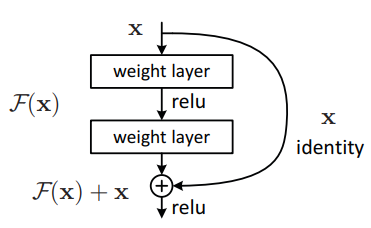

Despite being an efficient architectural choice to avoid vanishing gradient, it is still not clear why residual connections work as well as they do. One possible reason is given by [Hao Li et al., Visualizing the Loss Landscape of Neural Nets, NeurIPS 2018](https://arxiv.org/abs/1712.09913):

"*Neural network training relies on our ability to find "good" minimizers of highly non-convex loss functions. It is well-known that certain network architecture designs (e.g., skip connections) produce loss functions that train easier, and wellchosen training parameters (batch size, learning rate, optimizer) produce minimizers that generalize better. However, the reasons for these differences, and their effects on the underlying loss landscape, are not well understood. In this paper, we explore the structure of neural loss functions, and the effect of loss landscapes on generalization, using a range of visualization methods.*"

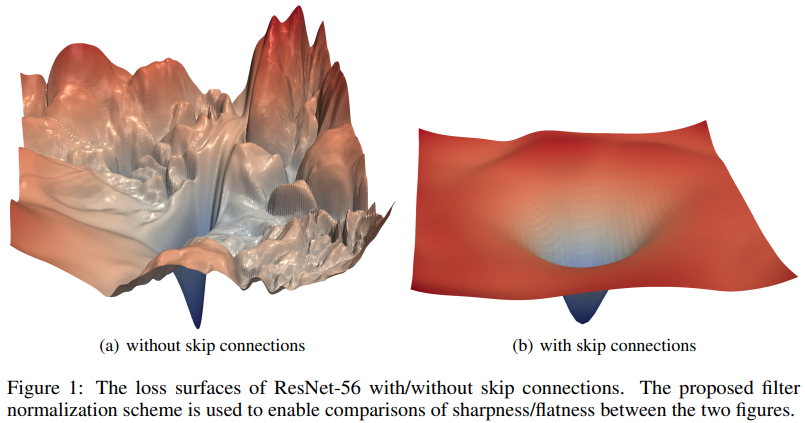

Another interesting insight ([Veit Andreas et al., Residual Networks Behave Like Ensembles of Relatively Shallow Networks, 2016](https://arxiv.org/abs/1605.06431)) about residual networks is that they behave as if they were an ensemble of models:

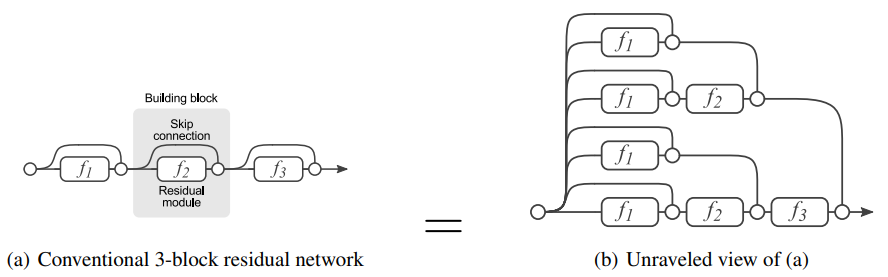

From this view, it is apparent that residual networks have $O(2^n)$ implicit paths connecting input and output and that adding a block doubles the number of paths.

From the subsequent figure, it is evident that deleting a layer in residual networks at test time (a) is equivalent to zeroing half of the paths. In ordinary feed-forward networks (b) such as VGG or AlexNet, deleting individual layers alters the only viable path from input to output.

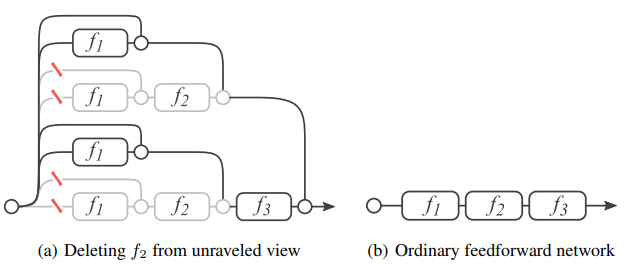

"*Why are residual networks resilient to dropping layers but VGG is not? Expressing residual networks in the unraveled view provides a first insight. It shows that residual networks can be seen as a collection of many paths. As illustrated, when a layer is removed, the number of paths is reduced from $2^n$ to $2^{n-1}$, leaving half the number of paths valid. VGG only contains a
single usable path from input to output. Thus, when a single layer is removed, the only viable path is corrupted. This result suggests that paths in a residual network do not strongly depend on each other although they are trained jointly.*"

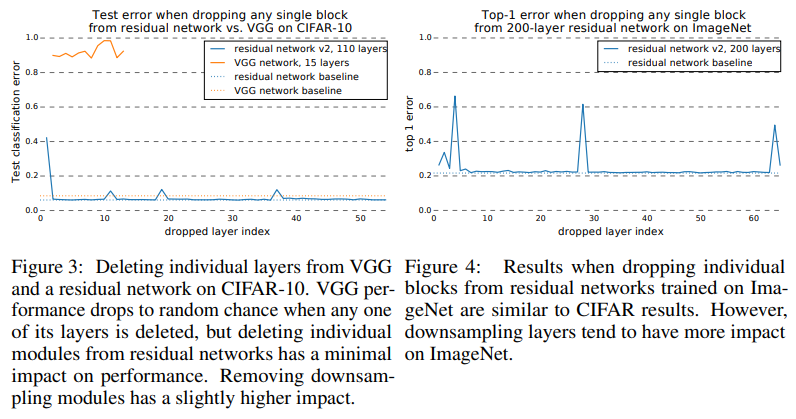

We implement the code to download and fine-tune the pretrained version of ResNet-18. To do this, we first download the model using `torchvision`. Then, we modify the architecture to suit our specific task. The top layer of the original ResNet-18 model, responsible for the final classification, is replaced with a new linear layer (`nn.Linear`) with an output size corresponding to the number of classes in our dermatologic image dataset.

In [ ]:
# Download and load the pretrained ResNet-18.
resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

# Replace the top layer for finetuning.
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Move model to device.
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.2MB/s]


Once downloaded and properly modified, the ResNet-18 model is fine-tuned for ten epochs and its performances are then evaluated.

In [ ]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

# Training and test.
for epoch in range(num_epochs):
    train_loss = train(epoch, resnet, train_loader, criterion, optimizer, device)
    test_loss, test_acc, y_true, y_pred = test(resnet, test_loader, criterion, device)
    print(f'Epoch {epoch+1:03d}: training loss {train_loss:.4f}, test loss {test_loss:.4f}, test acc {test_acc:.4f}')

Epoch 001: 100%|██████████| 110/110 [00:20<00:00,  5.34it/s]


Epoch 001: training loss 96.0277, test loss 80.3221, test acc 0.3885


Epoch 002: 100%|██████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 002: training loss 66.3863, test loss 70.7558, test acc 0.4359


Epoch 003: 100%|██████████| 110/110 [00:20<00:00,  5.45it/s]


Epoch 003: training loss 56.6051, test loss 73.6380, test acc 0.4544


Epoch 004: 100%|██████████| 110/110 [00:20<00:00,  5.47it/s]


Epoch 004: training loss 45.9779, test loss 63.7792, test acc 0.5187


Epoch 005: 100%|██████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 005: training loss 43.9848, test loss 63.0743, test acc 0.4823


Epoch 006: 100%|██████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 006: training loss 35.4196, test loss 57.9551, test acc 0.5676


Epoch 007: 100%|██████████| 110/110 [00:20<00:00,  5.42it/s]


Epoch 007: training loss 36.7981, test loss 67.0430, test acc 0.4738


Epoch 008: 100%|██████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 008: training loss 32.5316, test loss 53.9888, test acc 0.5935


Epoch 009: 100%|██████████| 110/110 [00:20<00:00,  5.44it/s]


Epoch 009: training loss 29.8015, test loss 62.9935, test acc 0.5322


Epoch 010: 100%|██████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 010: training loss 27.9769, test loss 68.7312, test acc 0.5207


In [ ]:
print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.25      0.70      0.37        66
           1       0.36      0.87      0.51       103
           2       0.44      0.66      0.53       220
           3       0.15      0.78      0.26        23
           4       0.35      0.57      0.44       223
           5       0.98      0.44      0.61      1341
           6       0.17      1.00      0.29        29

    accuracy                           0.52      2005
   macro avg       0.39      0.72      0.43      2005
weighted avg       0.78      0.52      0.56      2005

